In [8]:

from langchain_community.chat_models.openai import ChatOpenAI
import sys,os
sys.path.append("..")
from utils.general_utils import get_mermaid
from utils.img_utils import mermaid_txt_to_image

# 每类图表的PROMPT

In [9]:
SELECT_PROMPT = """
“{subject}”
=============
以上是从文章中提取的摘要,将会使用这些摘要绘制图表。请你选择一个合适的图表类型:
1 流程图
2 序列图
3 类图
4 饼图
5 甘特图
6 状态图
7 实体关系图
8 象限提示图
不需要解释原因，仅需要输出单个不带任何标点符号的数字。
"""
#没有思维导图!!!测试发现模型始终会优先选择思维导图
#流程图
PROMPT_1 = """
请你给出围绕“{subject}”的逻辑关系图，使用mermaid语法，mermaid语法举例：
```mermaid
graph TD
    P(编程) --> L1(Python)
    P(编程) --> L2(C)
    P(编程) --> L3(C++)
    P(编程) --> L4(Javascipt)
    P(编程) --> L5(PHP)
```
"""
#序列图
PROMPT_2 = """
请你给出围绕“{subject}”的序列图，使用mermaid语法，mermaid语法举例：
```mermaid
sequenceDiagram
    participant A as 用户
    participant B as 系统
    A->>B: 登录请求
    B->>A: 登录成功
    A->>B: 获取数据
    B->>A: 返回数据
```
"""
#类图
PROMPT_3 = """
请你给出围绕“{subject}”的类图，使用mermaid语法，mermaid语法举例：
```mermaid
classDiagram
    Class01 <|-- AveryLongClass : Cool
    Class03 *-- Class04
    Class05 o-- Class06
    Class07 .. Class08
    Class09 --> C2 : Where am i?
    Class09 --* C3
    Class09 --|> Class07
    Class07 : equals()
    Class07 : Object[] elementData
    Class01 : size()
    Class01 : int chimp
    Class01 : int gorilla
    Class08 <--> C2: Cool label
```
"""
#饼图
PROMPT_4 = """
请你给出围绕“{subject}”的饼图，使用mermaid语法，mermaid语法举例：
```mermaid
pie title Pets adopted by volunteers
    "狗" : 386
    "猫" : 85
    "兔子" : 15
```
"""
#甘特图
PROMPT_5 = """
请你给出围绕“{subject}”的甘特图，使用mermaid语法，mermaid语法举例：
```mermaid
gantt
    title 项目开发流程
    dateFormat  YYYY-MM-DD
    section 设计
    需求分析 :done, des1, 2024-01-06,2024-01-08
    原型设计 :active, des2, 2024-01-09, 3d
    UI设计 : des3, after des2, 5d
    section 开发
    前端开发 :2024-01-20, 10d
    后端开发 :2024-01-20, 10d
```
"""
#状态图
PROMPT_6 = """
请你给出围绕“{subject}”的状态图，使用mermaid语法，mermaid语法举例：
```mermaid
stateDiagram-v2
   [*] --> Still
    Still --> [*]
    Still --> Moving
    Moving --> Still
    Moving --> Crash
    Crash --> [*]
```
"""
#实体关系图
PROMPT_7 = """
请你给出围绕“{subject}”的实体关系图，使用mermaid语法，mermaid语法举例：
```mermaid
graph LR
    A[Hard skill] --> B(Programming)
    A[Hard skill] --> C(Design)
    D[Soft skill] --> E(Coordination)
    D[Soft skill] --> F(Communication)
```
"""
#象限提示图
PROMPT_8 = """
请你给出围绕“{subject}”的象限图，使用mermaid语法，mermaid语法举例：
```mermaid
graph LR
    A[Hard skill] --> B(Programming)
    A[Hard skill] --> C(Design)
    D[Soft skill] --> E(Coordination)
    D[Soft skill] --> F(Communication)
```
"""
#思维导图
PROMPT_9 = """
{subject}
==========
请给出上方内容的思维导图，充分考虑其之间的逻辑，使用mermaid语法，mermaid语法举例：
```mermaid
mindmap
  root((mindmap))
    Origins
      Long history
      ::icon(fa fa-book)
      Popularisation
        British popular psychology author Tony Buzan
    Research
      On effectiveness<br/>and features
      On Automatic creation
        Uses
            Creative techniques
            Strategic planning
            Argument mapping
    Tools
      Pen and paper
      Mermaid
```
"""

# 调用大模型生成Mermaid流程图/思维图

In [10]:

def get_mermaid(content,llm):
    # 设置OpenAI API密钥
    from dotenv import load_dotenv
    load_dotenv()
    # llm = ChatOpenAI()
    ############################## <第 0 步，切割输入> ##################################
    # 借用PDF切割中的函数对文本进行切割
    TOKEN_LIMIT_PER_FRAGMENT = 2500
    txt = str(content).encode('utf-8', 'ignore').decode()  # avoid reading non-utf8 chars
    txt = split_text_to_satisfy_token_limit(txt=txt, limit=TOKEN_LIMIT_PER_FRAGMENT)
    ############################## <第 1 步，迭代地历遍整个文章，提取精炼信息> ##################################
    results = []
    MAX_WORD_TOTAL = 4096
    n_txt = len(txt)
    last_iteration_result = "从以下文本中提取摘要。"
    if n_txt >= 20: print('文章极长，不能达到预期效果')
    for i in range(n_txt):
        NUM_OF_WORD = MAX_WORD_TOTAL // n_txt
        i_say = f"Read this section, recapitulate the content of this section with less than {NUM_OF_WORD} words in Chinese: {txt[i]}"
        sys_prompt = "Extracts the main content from the text section where it is located for graphing purposes, answer me with Chinese."
        # llm = ChatOpenAI(
        #     model_name="chatglm",
        #     openai_api_base="http://localhost:8000/v1",
        #     openai_api_key="EMPTY",
        #     streaming=False,
        # )
        # llm = ChatOpenAI()
        messages = [
            SystemMessage(content=sys_prompt),
            HumanMessage(content=i_say)
        ]
        # gpt_say = llm(messages)
        gpt_say = llm(messages).content
        results.append(gpt_say)
    ############################## <第 2 步，根据整理的摘要选择图表类型> ##################################
    results_txt = '\n'.join(results)  # 合并摘要
    # if gpt_say not in ['1', '2', '3', '4', '5', '6', '7', '8', '9']:  # 如插件参数不正确则使用对话模型判断
    #     i_say_show_user = f'接下来将判断适合的图表类型,如连续3次判断失败将会使用流程图进行绘制';
    gpt_say = "[Local Message] 收到。"  # 用户提示
    i_say = SELECT_PROMPT.format(subject=results_txt)
    i_say_show_user = f'请判断适合使用的流程图类型,其中数字对应关系为:1-流程图,2-序列图,3-类图,4-饼图,5-甘特图,6-状态图,7-实体关系图,8-象限提示图。由于不管提供文本是什么,模型大概率认为"思维导图"最合适,因此思维导图仅能通过参数调用。'
    # llm = ChatOpenAI(
    #     model_name="chatglm",
    #     openai_api_base="http://localhost:8000/v1",
    #     openai_api_key="EMPTY",
    #     streaming=False,
    # )

    for i in range(3):
        gpt_say = llm([HumanMessage(content=i_say)]).content
        if gpt_say in ['1', '2', '3', '4', '5', '6', '7', '8', '9']:  # 判断返回是否正确
            break
    if gpt_say not in ['1', '2', '3', '4', '5', '6', '7', '8', '9']:
        gpt_say = '1'
    ############################## <第 3 步，根据选择的图表类型绘制图表> ##################################
    if gpt_say == '1':
        i_say = PROMPT_1.format(subject=results_txt)
    elif gpt_say == '2':
        i_say = PROMPT_2.format(subject=results_txt)
    elif gpt_say == '3':
        i_say = PROMPT_3.format(subject=results_txt)
    elif gpt_say == '4':
        i_say = PROMPT_4.format(subject=results_txt)
    elif gpt_say == '5':
        i_say = PROMPT_5.format(subject=results_txt)
    elif gpt_say == '6':
        i_say = PROMPT_6.format(subject=results_txt)
    elif gpt_say == '7':
        i_say = PROMPT_7.replace("{subject}", results_txt)  # 由于实体关系图用到了{}符号
    elif gpt_say == '8':
        i_say = PROMPT_8.format(subject=results_txt)
    elif gpt_say == '9':
        i_say = PROMPT_9.format(subject=results_txt)
    i_say_show_user = f'请根据判断结果绘制相应的图表。如需绘制思维导图请使用参数调用,同时过大的图表可能需要复制到在线编辑器中进行渲染。'
    gpt_say = llm([HumanMessage(content=i_say)]).content
    return(gpt_say)

In [11]:
html =html = ['''
Paper:1
标题: AutoKG: Efficient Automated Knowledge Graph (自动知识图谱:高效自动化知识图谱)
Title: AutoKG: Efficient Automated Knowledge Graph
Authors: Bohan Chen and Andrea L. Bertozzi
Affiliation: Department of Mathematics, University of California, Los Angeles (加州大学洛杉矶分校数学系)
Keywords: Large Language Models, Knowledge Graph, Graph Learning, Retrieval-augmented Generation
Summary:
(1): 本文的研究背景是传统方法在将大型语言模型（LLMs）与知识库链接时往往无法捕捉复杂的关系动态。
(2): 过去的方法包括语义相似性搜索，存在问题是难以捕捉复杂的关系动态。本文的方法是有充分动机的，提出了一种轻量高效的自动化知识图谱构建方法。
(3): 本文提出的研究方法是通过使用LLM提取关键词，然后通过图拉普拉斯学习评估每对关键词之间的关系权重。使用向量相似性和基于图的关联的混合搜索方案来丰富LLM响应。
(4): 本文的方法在任务上取得了更全面和相互关联的知识检索机制，从而增强了LLMs在生成更具洞察力和相关性输出方面的能力。
Methods:
(1): 使用大型语言模型（LLMs）提取关键词。

(2): 通过图拉普拉斯学习评估每对关键词之间的关系权重。

(3): 利用向量相似性和基于图的关联的混合搜索方案来丰富LLMs响应。

(4): 通过构建更全面和相互关联的知识检索机制增强LLMs的生成能力。

Conclusion:
(1): 本研究的意义在于提出了一种轻量高效的自动化知识图谱构建方法，弥补了传统方法在捕捉复杂关系动态方面的不足。

(2): 创新点: 提出了基于大型语言模型（LLMs）的关键词提取和图拉普拉斯学习的方法，增强了知识检索机制；表现: 在任务上取得更全面和相互关联的知识检索机制；工作量: 通过轻量高效的自动化方法减少了工作量。''',
'''
Paper:2
标题 : ToC-RWG: 探索主题模型和引用信息的结合
Title: ToC-RWG: Explore the Combination of Topic Model and Citation Information
Authors: Pancheng Wang, Shasha Li
Affiliation: NUDT
Keywords: Related work generation, QueryTopicSum, CTS, topic model, citation information
Summary:
(1): 本文的研究背景是自动生成相关工作的领域。 (2): 过去的方法包括QueryTopicSum和CTS等，存在问题是没有充分考虑目标论文与引用论文之间的联系，因此本文提出的方法有很好的动机。 (3): 本文提出了一种新的研究方法ToC-RWG，结合了主题模型和引用信息。 (4): 该方法在相关工作生成任务上取得了很好的性能，支持他们的目标。

Methods:
(1): 本文提出了一种新的贝叶斯模型 QueryTopicSum，用于描述目标论文和引用论文的文本特征。

(2): 为了捕捉目标论文和引用论文之间的关系，引入了一种称为引文文本段（Cited Text Spans，CTS）的概念，用于识别与给定引文最相关的匹配文本段。

(3): 为了将引文与目标论文联系起来，作者人工收集了一些引文，并利用之前开发的CTS识别技术，识别出作为相关工作生成候选句子的显著句子。

Conclusion:
(1): 本文的意义在于提出了一种新颖的模型 ToC-RWG，结合了主题模型和引用信息，用于自动生成相关工作，填补了先前方法在考虑目标论文与引用论文联系方面的不足。

(2): Innovation point: 提出了结合主题模型和引用信息的 ToC-RWG 模型，弥补了以往方法在考虑目标论文与引用论文联系方面的不足; Performance: 在相关工作生成任务上取得了良好性能; Workload: 作者未提及具体的工作量评估。
''']

# 生成图片并保存

In [12]:
def generate_img():
    try:
        print("MERMAIDING______")
        for index, report_html in enumerate(html):
            # 在这里处理每个索引和对应的报告HTML内容
            print("Index:", index)
#             print("Report HTML:", report_html)
            from dotenv import load_dotenv
            load_dotenv()
            llm = ChatOpenAI()
            mermaid_text = get_mermaid(report_html, llm)

            def replace_code_blocks(string):
                string = string.replace("```mermaid", "")
                string = string.replace("```", "")
                return string

            mermaid_text = replace_code_blocks(mermaid_text)
            print("mermaid_text:", mermaid_text)

            mermaid_txt_to_image(mermaid_text, "diagram{}.png".format(index + 1))


            print('成功生成思维图')

    except Exception as e:
        # 异常处理代码
        print("发生异常:", str(e))

In [13]:
generate_img()

MERMAIDING______
Index: 0


D:\Users\wtqiu\AppData\Local\anaconda3\envs\glm\lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.chat_models.openai.ChatOpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


发生异常: name 'split_text_to_satisfy_token_limit' is not defined


# 读取图片并展示

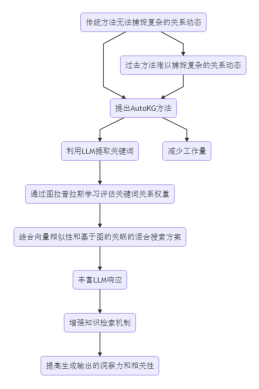

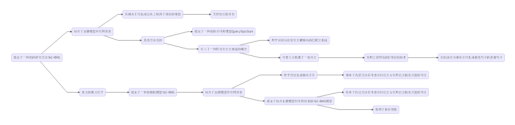

In [51]:
import glob
from PIL import Image
import matplotlib.pyplot as plt

# 文件夹路径
folder_path = r'D:\Pycharm_Projects\report-generate-webui\src\assets\mermaid_imgs'

# 获取文件夹下所有图片的文件路径
image_paths = glob.glob(folder_path + '/*.png')  # 可根据实际情况修改文件类型后缀
# 遍历图片文件路径
for image_path in image_paths:
    # 打开图片
    image = Image.open(image_path)

    # 展示图片
    plt.imshow(image)
    plt.axis('off')  # 不显示坐标轴
    plt.show()